# 📊 Analyse des Données d'Emploi Adzuna

Ce notebook charge les données JSON d'Adzuna et les transforme en DataFrame pandas pour l'analyse.


In [18]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Configuration matplotlib pour de meilleurs rendus
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

print("✅ Librairies importées avec succès !")


✅ Librairies importées avec succès !


## 📂 Chargement des données JSON


In [19]:
# Charger le fichier JSON
with open('../data/jobs_data.json', 'r', encoding='utf-8') as f:
    data = json.load(f)

# Afficher les métadonnées
print("📊 Métadonnées du dataset:")
for key, value in data['metadata'].items():
    print(f"  {key}: {value}")

print(f"\n📋 Nombre total d'offres dans le JSON: {len(data['jobs'])}")

# Aperçu de la première offre pour comprendre la structure
print(f"\n👀 Structure d'une offre d'emploi:")
if data['jobs']:
    first_job = data['jobs'][0]
    for key, value in first_job.items():
        if isinstance(value, dict):
            print(f"  {key}: {type(value)} - {list(value.keys())}")
        elif isinstance(value, list):
            print(f"  {key}: {type(value)} - {len(value)} éléments")
        else:
            print(f"  {key}: {type(value)} - {str(value)[:50]}{'...' if len(str(value)) > 50 else ''}")


📊 Métadonnées du dataset:
  search_term: data
  total_jobs: 35000
  scraping_date: 2025-12-18T19:09:18.708384
  api_source: Adzuna

📋 Nombre total d'offres dans le JSON: 35000

👀 Structure d'une offre d'emploi:
  redirect_url: <class 'str'> - https://www.adzuna.fr/land/ad/5542885988?se=BtPR9T...
  salary_is_predicted: <class 'str'> - 0
  longitude: <class 'float'> - 2.344631
  __CLASS__: <class 'str'> - Adzuna::API::Response::Job
  created: <class 'str'> - 2025-12-15T10:38:40Z
  latitude: <class 'float'> - 48.863839
  adref: <class 'str'> - eyJhbGciOiJIUzI1NiJ9.eyJpIjoiNTU0Mjg4NTk4OCIsInMiO...
  title: <class 'str'> - Accelerator Data Science (Paris)
  company: <class 'dict'> - ['display_name', '__CLASS__']
  category: <class 'dict'> - ['__CLASS__', 'label', 'tag']
  location: <class 'dict'> - ['__CLASS__', 'display_name', 'area']
  description: <class 'str'> - Le contenu du poste est libellé en anglais car il ...
  id: <class 'str'> - 5542885988


## 🔄 Transformation en DataFrame pandas


## 🔍 Statistiques descriptives

Avant de plonger dans l'analyse, examinons la structure et la qualité des données.


In [24]:
def flatten_job_data(job):
    """
    Transforme un objet job complexe en dictionnaire plat pour pandas
    """
    flattened = {}
    
    # Champs simples
    simple_fields = ['id', 'title', 'description', 'created', 'contract_type', 
                    'contract_time', 'salary_min', 'salary_max', 'salary_is_predicted',
                    'latitude', 'longitude', 'redirect_url']
    
    for field in simple_fields:
        flattened[field] = job.get(field, None)
    
    # Champs complexes - Company
    company = job.get('company', {})
    flattened['company_name'] = company.get('display_name', None)
    
    # Champs complexes - Location
    location = job.get('location', {})
    flattened['location_display'] = location.get('display_name', None)
    
    area = location.get('area', [])
    flattened['country'] = area[0] if len(area) > 0 else None
    flattened['region'] = area[1] if len(area) > 1 else None
    flattened['department'] = area[2] if len(area) > 2 else None
    flattened['city'] = area[-1] if len(area) > 0 else None
    
    # Champs complexes - Category
    category = job.get('category', {})
    flattened['category_label'] = category.get('label', None)
    flattened['category_tag'] = category.get('tag', None)
    
    return flattened

# Transformer toutes les offres
jobs_flattened = [flatten_job_data(job) for job in data['jobs']]

# Créer le DataFrame
df_jobs = pd.DataFrame(jobs_flattened)

print(f"✅ DataFrame créé avec {len(df_jobs)} lignes et {len(df_jobs.columns)} colonnes")
print(f"\n📋 Colonnes disponibles:")
for i, col in enumerate(df_jobs.columns, 1):
    print(f"  {i:2d}. {col}")


✅ DataFrame créé avec 35000 lignes et 20 colonnes

📋 Colonnes disponibles:
   1. id
   2. title
   3. description
   4. created
   5. contract_type
   6. contract_time
   7. salary_min
   8. salary_max
   9. salary_is_predicted
  10. latitude
  11. longitude
  12. redirect_url
  13. company_name
  14. location_display
  15. country
  16. region
  17. department
  18. city
  19. category_label
  20. category_tag


In [ ]:
# Informations sur la structure du DataFrame
print("📊 STRUCTURE DU DATAFRAME")
print("=" * 60)
df_jobs.info()

print("\n" + "=" * 60)
print("\n💰 STATISTIQUES DES SALAIRES")
print("=" * 60)
print(df_jobs[['salary_min_k', 'salary_max_k', 'salary_avg_k']].describe())

print("\n" + "=" * 60)
print("\n📍 STATISTIQUES GÉOGRAPHIQUES")
print("=" * 60)
print(f"Latitude - Min: {df_jobs['latitude'].min():.2f}, Max: {df_jobs['latitude'].max():.2f}")
print(f"Longitude - Min: {df_jobs['longitude'].min():.2f}, Max: {df_jobs['longitude'].max():.2f}")


📊 STRUCTURE DU DATAFRAME


AttributeError: 'dict' object has no attribute 'info'

## 📉 Analyse des valeurs manquantes

Comprendre où et combien de données manquent.


In [ ]:
# Calcul des valeurs manquantes
missing_data = pd.DataFrame({
    'Column': df_jobs.columns,
    'Missing_Count': df_jobs.isnull().sum(),
    'Missing_Percentage': (df_jobs.isnull().sum() / len(df_jobs) * 100).round(2)
})

# Trier par pourcentage décroissant
missing_data = missing_data[missing_data['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False)

print("🔍 VALEURS MANQUANTES PAR COLONNE")
print("=" * 70)
for idx, row in missing_data.iterrows():
    bar_length = int(row['Missing_Percentage'] / 2)
    bar = "█" * bar_length
    print(f"{row['Column']:25} | {bar:50} | {row['Missing_Count']:6} ({row['Missing_Percentage']:5.1f}%)")

print(f"\n✅ Colonnes complètes (sans NaN): {len(df_jobs.columns) - len(missing_data)}/{len(df_jobs.columns)}")


## 📊 Visualisations - Analyse Salariale

Exploration visuelle des données de salaires.


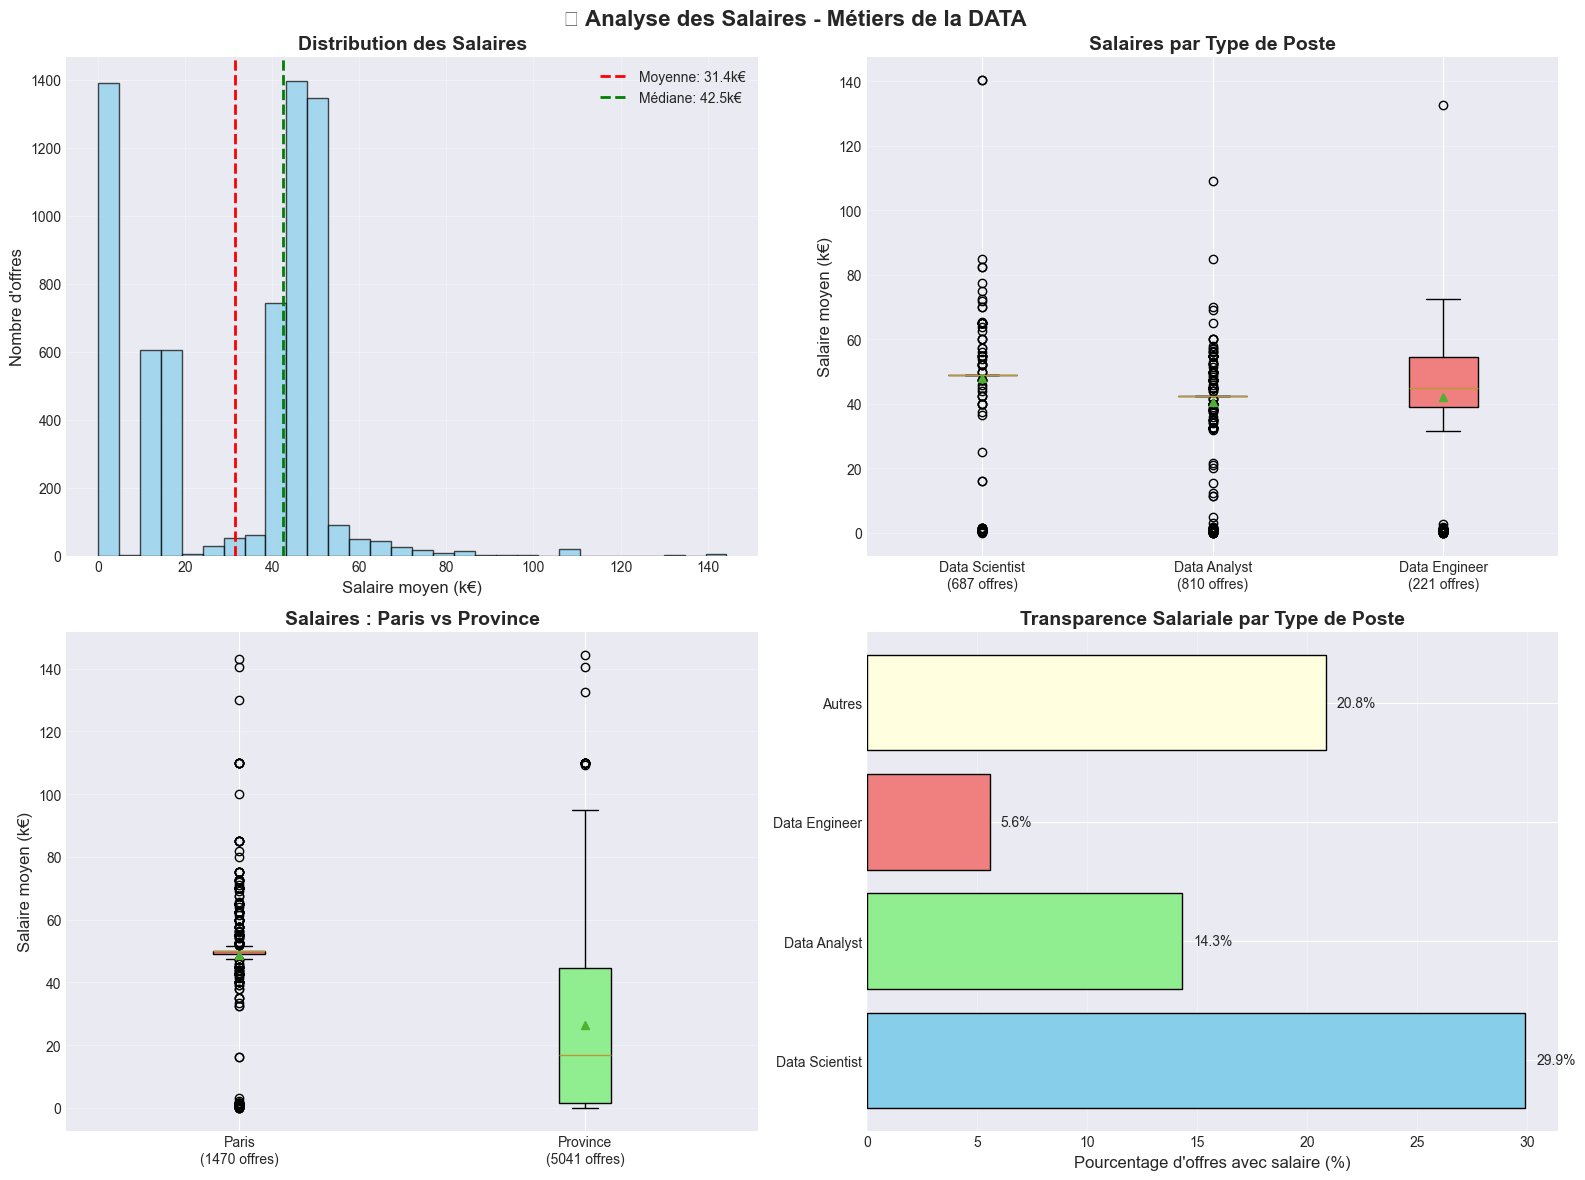

✅ Visualisations des salaires générées avec succès!


In [14]:
# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Créer une figure avec plusieurs sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('📊 Analyse des Salaires - Métiers de la DATA', fontsize=16, fontweight='bold')

# 1. Distribution des salaires (histogramme)
salary_data = df_jobs.dropna(subset=['salary_avg_k'])
salary_data_filtered = salary_data[salary_data['salary_avg_k'] < 150]  # Filtrer les outliers

axes[0, 0].hist(salary_data_filtered['salary_avg_k'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(salary_data_filtered['salary_avg_k'].mean(), color='red', linestyle='--', linewidth=2, label=f'Moyenne: {salary_data_filtered["salary_avg_k"].mean():.1f}k€')
axes[0, 0].axvline(salary_data_filtered['salary_avg_k'].median(), color='green', linestyle='--', linewidth=2, label=f'Médiane: {salary_data_filtered["salary_avg_k"].median():.1f}k€')
axes[0, 0].set_xlabel('Salaire moyen (k€)', fontsize=12)
axes[0, 0].set_ylabel('Nombre d\'offres', fontsize=12)
axes[0, 0].set_title('Distribution des Salaires', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Boxplot par type de poste
job_types_salary = []
labels = []
for job_type, column in [('Data Scientist', 'is_data_scientist'), 
                         ('Data Analyst', 'is_data_analyst'), 
                         ('Data Engineer', 'is_data_engineer')]:
    subset = df_jobs[df_jobs[column] & df_jobs['salary_avg_k'].notna() & (df_jobs['salary_avg_k'] < 150)]
    if len(subset) > 10:
        job_types_salary.append(subset['salary_avg_k'])
        labels.append(f"{job_type}\n({len(subset)} offres)")

bp = axes[0, 1].boxplot(job_types_salary, labels=labels, patch_artist=True, showmeans=True)
for patch, color in zip(bp['boxes'], ['lightblue', 'lightgreen', 'lightcoral']):
    patch.set_facecolor(color)
axes[0, 1].set_ylabel('Salaire moyen (k€)', fontsize=12)
axes[0, 1].set_title('Salaires par Type de Poste', fontsize=14, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 3. Salaires Paris vs Province
paris_salary = df_jobs[df_jobs['is_paris'] & df_jobs['salary_avg_k'].notna() & (df_jobs['salary_avg_k'] < 150)]['salary_avg_k']
province_salary = df_jobs[~df_jobs['is_paris'] & df_jobs['salary_avg_k'].notna() & (df_jobs['salary_avg_k'] < 150)]['salary_avg_k']

if len(paris_salary) > 0 and len(province_salary) > 0:
    data_loc = [paris_salary, province_salary]
    bp2 = axes[1, 0].boxplot(data_loc, labels=[f'Paris\n({len(paris_salary)} offres)', f'Province\n({len(province_salary)} offres)'], 
                              patch_artist=True, showmeans=True)
    bp2['boxes'][0].set_facecolor('lightcoral')
    bp2['boxes'][1].set_facecolor('lightgreen')
    axes[1, 0].set_ylabel('Salaire moyen (k€)', fontsize=12)
    axes[1, 0].set_title('Salaires : Paris vs Province', fontsize=14, fontweight='bold')
    axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Pourcentage d'offres avec salaire par type
salary_rates = []
job_labels = []
for job_type, column in [('Data Scientist', 'is_data_scientist'), 
                         ('Data Analyst', 'is_data_analyst'), 
                         ('Data Engineer', 'is_data_engineer'),
                         ('Autres', None)]:
    if column:
        subset = df_jobs[df_jobs[column]]
    else:
        subset = df_jobs[~(df_jobs['is_data_scientist'] | df_jobs['is_data_analyst'] | df_jobs['is_data_engineer'])]
    
    if len(subset) > 0:
        rate = (subset['salary_avg_k'].notna().sum() / len(subset)) * 100
        salary_rates.append(rate)
        job_labels.append(job_type)

colors_bar = ['skyblue', 'lightgreen', 'lightcoral', 'lightyellow']
bars = axes[1, 1].barh(job_labels, salary_rates, color=colors_bar[:len(job_labels)], edgecolor='black')
axes[1, 1].set_xlabel('Pourcentage d\'offres avec salaire (%)', fontsize=12)
axes[1, 1].set_title('Transparence Salariale par Type de Poste', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='x')

# Ajouter les valeurs sur les barres
for i, (bar, value) in enumerate(zip(bars, salary_rates)):
    axes[1, 1].text(value + 0.5, i, f'{value:.1f}%', va='center', fontsize=10)

plt.tight_layout()
plt.show()

print(f"✅ Visualisations des salaires générées avec succès!")


## 🏢 Visualisations - Entreprises et Localisations

Top recruteurs et zones géographiques.


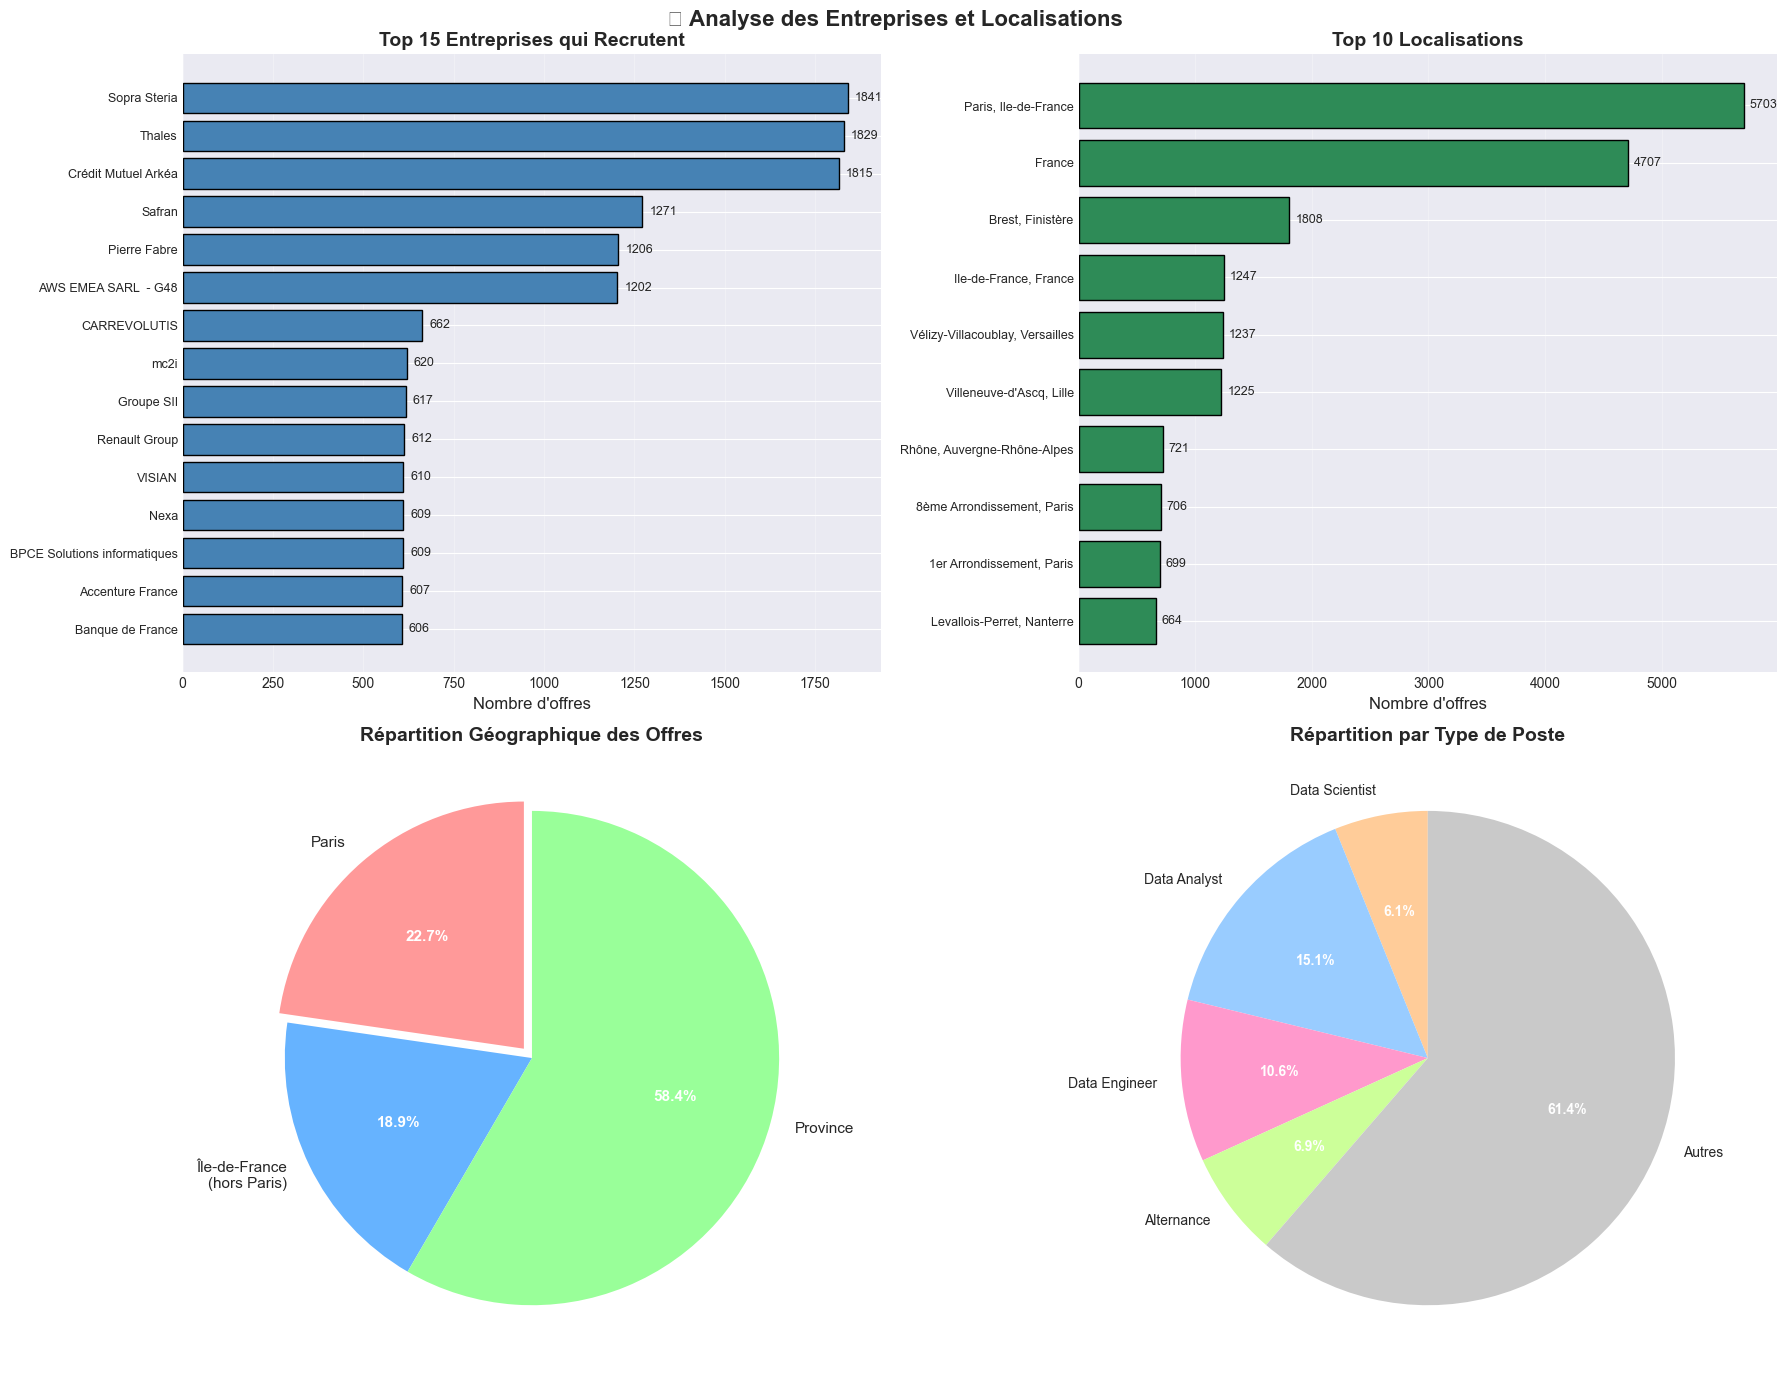

✅ Visualisations entreprises/localisations générées avec succès!


In [15]:
# Créer une figure avec plusieurs sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(18, 14))
fig.suptitle('🏢 Analyse des Entreprises et Localisations', fontsize=16, fontweight='bold')

# 1. Top 15 entreprises
top_companies = df_jobs['company_name'].value_counts().head(15)
axes[0, 0].barh(range(len(top_companies)), top_companies.values, color='steelblue', edgecolor='black')
axes[0, 0].set_yticks(range(len(top_companies)))
axes[0, 0].set_yticklabels(top_companies.index, fontsize=9)
axes[0, 0].set_xlabel('Nombre d\'offres', fontsize=12)
axes[0, 0].set_title('Top 15 Entreprises qui Recrutent', fontsize=14, fontweight='bold')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3, axis='x')

# Ajouter les valeurs sur les barres
for i, value in enumerate(top_companies.values):
    axes[0, 0].text(value + 20, i, str(value), va='center', fontsize=9)

# 2. Top 10 villes/localisations
top_locations = df_jobs['location_display'].value_counts().head(10)
axes[0, 1].barh(range(len(top_locations)), top_locations.values, color='seagreen', edgecolor='black')
axes[0, 1].set_yticks(range(len(top_locations)))
axes[0, 1].set_yticklabels(top_locations.index, fontsize=9)
axes[0, 1].set_xlabel('Nombre d\'offres', fontsize=12)
axes[0, 1].set_title('Top 10 Localisations', fontsize=14, fontweight='bold')
axes[0, 1].invert_yaxis()
axes[0, 1].grid(True, alpha=0.3, axis='x')

# Ajouter les valeurs sur les barres
for i, value in enumerate(top_locations.values):
    axes[0, 1].text(value + 50, i, str(value), va='center', fontsize=9)

# 3. Répartition Paris vs Île-de-France vs Province
geo_distribution = {
    'Paris': df_jobs['is_paris'].sum(),
    'Île-de-France\n(hors Paris)': df_jobs['is_ile_de_france'].sum() - df_jobs['is_paris'].sum(),
    'Province': len(df_jobs) - df_jobs['is_ile_de_france'].sum()
}

colors_pie = ['#ff9999', '#66b3ff', '#99ff99']
wedges, texts, autotexts = axes[1, 0].pie(geo_distribution.values(), 
                                            labels=geo_distribution.keys(), 
                                            autopct='%1.1f%%',
                                            startangle=90,
                                            colors=colors_pie,
                                            explode=(0.05, 0, 0),
                                            textprops={'fontsize': 11})
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
axes[1, 0].set_title('Répartition Géographique des Offres', fontsize=14, fontweight='bold')

# 4. Répartition par type de poste
job_types_count = {
    'Data Scientist': df_jobs['is_data_scientist'].sum(),
    'Data Analyst': df_jobs['is_data_analyst'].sum(),
    'Data Engineer': df_jobs['is_data_engineer'].sum(),
    'Alternance': df_jobs['is_alternance'].sum(),
    'Autres': len(df_jobs) - (df_jobs['is_data_scientist'].sum() + df_jobs['is_data_analyst'].sum() + df_jobs['is_data_engineer'].sum())
}

colors_pie2 = ['#ffcc99', '#99ccff', '#ff99cc', '#ccff99', '#c9c9c9']
wedges2, texts2, autotexts2 = axes[1, 1].pie([v for v in job_types_count.values()], 
                                               labels=job_types_count.keys(), 
                                               autopct='%1.1f%%',
                                               startangle=90,
                                               colors=colors_pie2,
                                               textprops={'fontsize': 10})
for autotext in autotexts2:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
axes[1, 1].set_title('Répartition par Type de Poste', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"✅ Visualisations entreprises/localisations générées avec succès!")


## 📅 Analyse Temporelle

Évolution des offres d'emploi dans le temps.


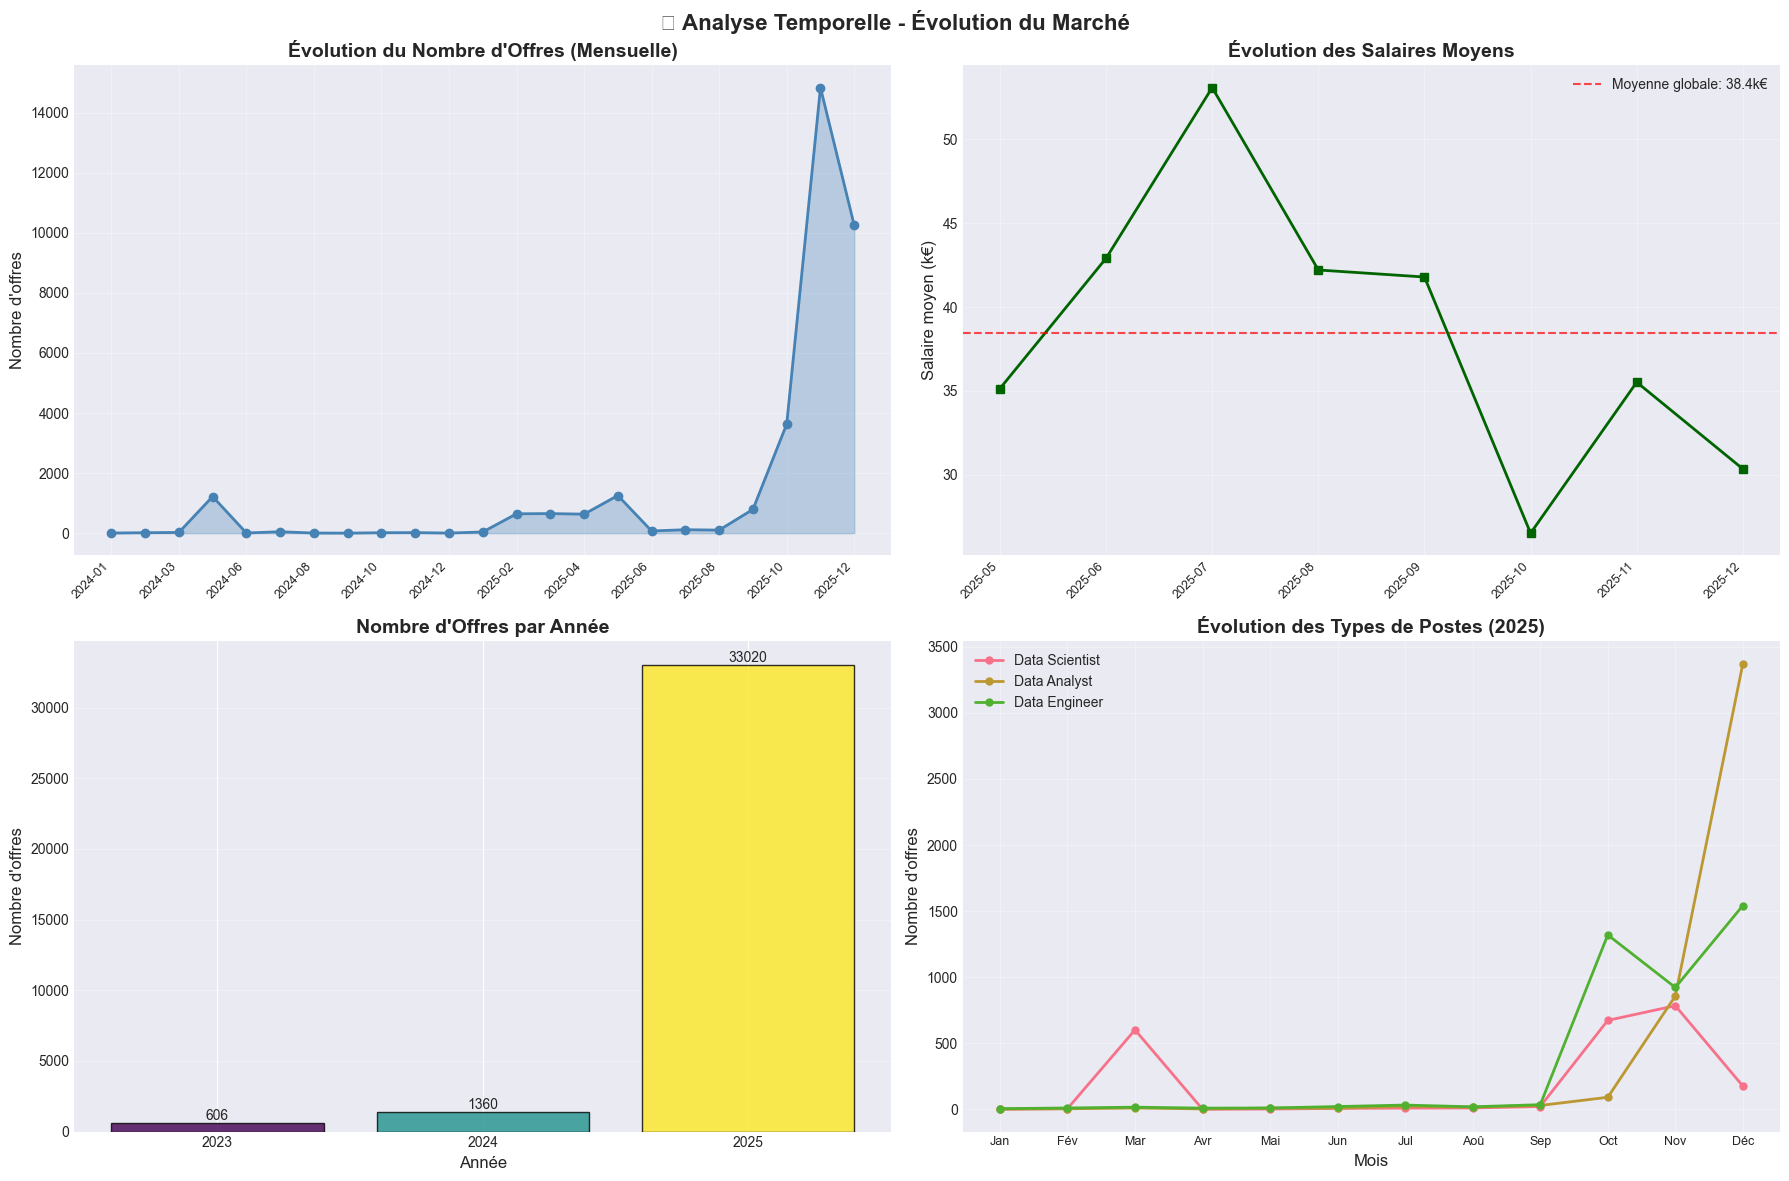

✅ Analyse temporelle générée avec succès!
📊 Période analysée: 2017-10-20 à 2025-12-18


In [16]:
# Créer une figure avec plusieurs sous-graphiques
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('📅 Analyse Temporelle - Évolution du Marché', fontsize=16, fontweight='bold')

# Préparer les données temporelles
df_jobs['year'] = df_jobs['created'].dt.year
df_jobs['month'] = df_jobs['created'].dt.month
df_jobs['year_month'] = df_jobs['created'].dt.to_period('M')

# Filtrer les données récentes (2 dernières années)
recent_data = df_jobs[df_jobs['year'] >= df_jobs['year'].max() - 1]

# 1. Nombre d'offres par mois (2 dernières années)
monthly_counts = recent_data.groupby('year_month').size().sort_index()
axes[0, 0].plot(range(len(monthly_counts)), monthly_counts.values, marker='o', linewidth=2, markersize=6, color='steelblue')
axes[0, 0].fill_between(range(len(monthly_counts)), monthly_counts.values, alpha=0.3, color='steelblue')
axes[0, 0].set_xticks(range(0, len(monthly_counts), max(1, len(monthly_counts)//10)))
axes[0, 0].set_xticklabels([str(monthly_counts.index[i]) for i in range(0, len(monthly_counts), max(1, len(monthly_counts)//10))], rotation=45, ha='right', fontsize=9)
axes[0, 0].set_ylabel('Nombre d\'offres', fontsize=12)
axes[0, 0].set_title('Évolution du Nombre d\'Offres (Mensuelle)', fontsize=14, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# 2. Évolution des salaires moyens dans le temps
salary_by_month = recent_data[recent_data['salary_avg_k'].notna()].groupby('year_month')['salary_avg_k'].agg(['mean', 'count'])
salary_by_month = salary_by_month[salary_by_month['count'] >= 10]  # Minimum 10 offres pour être pertinent

if len(salary_by_month) > 0:
    axes[0, 1].plot(range(len(salary_by_month)), salary_by_month['mean'].values, marker='s', linewidth=2, markersize=6, color='darkgreen')
    axes[0, 1].set_xticks(range(0, len(salary_by_month), max(1, len(salary_by_month)//8)))
    axes[0, 1].set_xticklabels([str(salary_by_month.index[i]) for i in range(0, len(salary_by_month), max(1, len(salary_by_month)//8))], rotation=45, ha='right', fontsize=9)
    axes[0, 1].set_ylabel('Salaire moyen (k€)', fontsize=12)
    axes[0, 1].set_title('Évolution des Salaires Moyens', fontsize=14, fontweight='bold')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].axhline(salary_by_month['mean'].mean(), color='red', linestyle='--', alpha=0.7, label=f'Moyenne globale: {salary_by_month["mean"].mean():.1f}k€')
    axes[0, 1].legend()

# 3. Nombre d'offres par année (vue d'ensemble)
yearly_counts = df_jobs.groupby('year').size().sort_index()
# Exclure les années avec très peu de données (probablement incomplètes)
yearly_counts = yearly_counts[yearly_counts > 100]

colors = plt.cm.viridis(np.linspace(0, 1, len(yearly_counts)))
bars = axes[1, 0].bar(yearly_counts.index.astype(str), yearly_counts.values, color=colors, edgecolor='black', alpha=0.8)
axes[1, 0].set_xlabel('Année', fontsize=12)
axes[1, 0].set_ylabel('Nombre d\'offres', fontsize=12)
axes[1, 0].set_title('Nombre d\'Offres par Année', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                     f'{int(height)}',
                     ha='center', va='bottom', fontsize=10)

# 4. Distribution des types de postes dans le temps (année actuelle)
current_year = df_jobs['year'].max()
current_year_data = df_jobs[df_jobs['year'] == current_year]

job_type_evolution = pd.DataFrame({
    'Data Scientist': current_year_data.groupby('month')['is_data_scientist'].sum(),
    'Data Analyst': current_year_data.groupby('month')['is_data_analyst'].sum(),
    'Data Engineer': current_year_data.groupby('month')['is_data_engineer'].sum()
})

if len(job_type_evolution) > 0:
    job_type_evolution.plot(kind='line', ax=axes[1, 1], marker='o', linewidth=2, markersize=5)
    axes[1, 1].set_xlabel('Mois', fontsize=12)
    axes[1, 1].set_ylabel('Nombre d\'offres', fontsize=12)
    axes[1, 1].set_title(f'Évolution des Types de Postes ({current_year})', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
    axes[1, 1].legend(fontsize=10)
    axes[1, 1].set_xticks(range(1, 13))
    axes[1, 1].set_xticklabels(['Jan', 'Fév', 'Mar', 'Avr', 'Mai', 'Jun', 'Jul', 'Aoû', 'Sep', 'Oct', 'Nov', 'Déc'], fontsize=9)

plt.tight_layout()
plt.show()

print(f"✅ Analyse temporelle générée avec succès!")
print(f"📊 Période analysée: {df_jobs['created'].min().strftime('%Y-%m-%d')} à {df_jobs['created'].max().strftime('%Y-%m-%d')}")


## 💾 Export des Données

Sauvegarde du DataFrame nettoyé pour utilisation ultérieure.


In [17]:
# Exporter le DataFrame nettoyé en CSV
output_path = '../data/jobs_data_clean.csv'

# Sélectionner les colonnes pertinentes pour l'export
columns_to_export = [
    'id', 'title', 'company_name', 'created',
    'salary_min_k', 'salary_max_k', 'salary_avg_k',
    'contract_type', 'contract_time',
    'location_display', 'country', 'region', 'department', 'city',
    'latitude', 'longitude',
    'category_label', 'category_tag',
    'is_paris', 'is_ile_de_france',
    'is_data_scientist', 'is_data_analyst', 'is_data_engineer', 'is_alternance',
    'description_length', 'redirect_url'
]

df_export = df_jobs[columns_to_export].copy()

# Exporter en CSV
df_export.to_csv(output_path, index=False, encoding='utf-8')

print(f"✅ Export réussi!")
print(f"📁 Fichier: {output_path}")
print(f"📊 {len(df_export)} lignes × {len(df_export.columns)} colonnes exportées")
print(f"💾 Taille du fichier: {os.path.getsize(output_path) / 1024 / 1024:.2f} MB")

# Afficher un aperçu des données exportées
print(f"\n👀 Aperçu des données exportées:")
print(df_export.head(3).to_string())


✅ Export réussi!
📁 Fichier: ../data/jobs_data_clean.csv
📊 35000 lignes × 26 colonnes exportées


NameError: name 'os' is not defined

## 📋 Résumé de l'Analyse

Récapitulatif des insights principaux tirés de l'analyse.


In [ ]:
print("=" * 80)
print("📊 RÉSUMÉ DE L'ANALYSE - MARCHÉ DE L'EMPLOI DATA EN FRANCE")
print("=" * 80)

# Statistiques générales
print(f"\n🔢 STATISTIQUES GÉNÉRALES")
print(f"   • Total d'offres analysées: {len(df_jobs):,}")
print(f"   • Période: {df_jobs['created'].min().strftime('%d/%m/%Y')} → {df_jobs['created'].max().strftime('%d/%m/%Y')}")
print(f"   • Entreprises différentes: {df_jobs['company_name'].nunique()}")
print(f"   • Localisations uniques: {df_jobs['location_display'].nunique()}")

# Insights salariaux
salary_data = df_jobs.dropna(subset=['salary_avg_k'])
if len(salary_data) > 0:
    print(f"\n💰 INSIGHTS SALARIAUX")
    print(f"   • Transparence salariale: {len(salary_data)/len(df_jobs)*100:.1f}% des offres")
    print(f"   • Salaire médian: {salary_data['salary_avg_k'].median():.1f}k€")
    print(f"   • Salaire moyen: {salary_data['salary_avg_k'].mean():.1f}k€")
    print(f"   • Fourchette interquartile: {salary_data['salary_avg_k'].quantile(0.25):.1f}k€ - {salary_data['salary_avg_k'].quantile(0.75):.1f}k€")

# Répartition des postes
print(f"\n🎯 RÉPARTITION PAR TYPE DE POSTE")
print(f"   • Data Analyst: {df_jobs['is_data_analyst'].sum():,} offres ({df_jobs['is_data_analyst'].mean()*100:.1f}%)")
print(f"   • Data Engineer: {df_jobs['is_data_engineer'].sum():,} offres ({df_jobs['is_data_engineer'].mean()*100:.1f}%)")
print(f"   • Data Scientist: {df_jobs['is_data_scientist'].sum():,} offres ({df_jobs['is_data_scientist'].mean()*100:.1f}%)")
print(f"   • Alternance: {df_jobs['is_alternance'].sum():,} offres ({df_jobs['is_alternance'].mean()*100:.1f}%)")

# Géographie
print(f"\n📍 RÉPARTITION GÉOGRAPHIQUE")
print(f"   • Paris: {df_jobs['is_paris'].sum():,} offres ({df_jobs['is_paris'].mean()*100:.1f}%)")
print(f"   • Île-de-France: {df_jobs['is_ile_de_france'].sum():,} offres ({df_jobs['is_ile_de_france'].mean()*100:.1f}%)")
print(f"   • Province: {(~df_jobs['is_ile_de_france']).sum():,} offres ({(~df_jobs['is_ile_de_france']).mean()*100:.1f}%)")

# Top recruteurs
print(f"\n🏢 TOP 5 RECRUTEURS")
for i, (company, count) in enumerate(df_jobs['company_name'].value_counts().head(5).items(), 1):
    print(f"   {i}. {company}: {count:,} offres")

# Salaires par métier
print(f"\n💵 SALAIRES MOYENS PAR MÉTIER (avec données)")
for job_type, column in [('Data Scientist', 'is_data_scientist'), 
                         ('Data Engineer', 'is_data_engineer'),
                         ('Data Analyst', 'is_data_analyst')]:
    subset = df_jobs[df_jobs[column] & df_jobs['salary_avg_k'].notna()]
    if len(subset) > 0:
        print(f"   • {job_type}: {subset['salary_avg_k'].mean():.1f}k€ (basé sur {len(subset)} offres)")

print(f"\n📁 FICHIERS GÉNÉRÉS")
print(f"   • DataFrame pandas: df_jobs ({len(df_jobs)} lignes × {len(df_jobs.columns)} colonnes)")
print(f"   • Export CSV: ../data/jobs_data_clean.csv")

print("\n" + "=" * 80)
print("✅ ANALYSE TERMINÉE - Notebook prêt pour des analyses personnalisées !")
print("=" * 80)


📊 RÉSUMÉ DE L'ANALYSE - MARCHÉ DE L'EMPLOI DATA EN FRANCE

🔢 STATISTIQUES GÉNÉRALES
   • Total d'offres analysées: 35,000
   • Période: 20/10/2017 → 18/12/2025
   • Entreprises différentes: 1737
   • Localisations uniques: 518

💰 INSIGHTS SALARIAUX
   • Transparence salariale: 18.6% des offres
   • Salaire médian: 42.5k€
   • Salaire moyen: 31.8k€
   • Fourchette interquartile: 12.3k€ - 48.5k€

🎯 RÉPARTITION PAR TYPE DE POSTE
   • Data Analyst: 5,668 offres (16.2%)
   • Data Engineer: 3,982 offres (11.4%)
   • Data Scientist: 2,297 offres (6.6%)
   • Alternance: 2,576 offres (7.4%)

📍 RÉPARTITION GÉOGRAPHIQUE
   • Paris: 7,946 offres (22.7%)
   • Île-de-France: 14,563 offres (41.6%)
   • Province: 20,437 offres (58.4%)

🏢 TOP 5 RECRUTEURS
   1. Sopra Steria: 1,841 offres
   2. Thales: 1,829 offres
   3. Crédit Mutuel Arkéa: 1,815 offres
   4. Safran: 1,271 offres
   5. Pierre Fabre: 1,206 offres

💵 SALAIRES MOYENS PAR MÉTIER (avec données)
   • Data Scientist: 48.2k€ (basé sur 687 offr

## 🧹 Nettoyage et enrichissement des données


In [10]:
# Conversion des types de données
df_jobs['created'] = pd.to_datetime(df_jobs['created'])
df_jobs['salary_min'] = pd.to_numeric(df_jobs['salary_min'], errors='coerce')
df_jobs['salary_max'] = pd.to_numeric(df_jobs['salary_max'], errors='coerce')
df_jobs['latitude'] = pd.to_numeric(df_jobs['latitude'], errors='coerce')
df_jobs['longitude'] = pd.to_numeric(df_jobs['longitude'], errors='coerce')

# Calcul de salaires moyens et conversion en k€
df_jobs['salary_avg'] = (df_jobs['salary_min'] + df_jobs['salary_max']) / 2
df_jobs['salary_min_k'] = df_jobs['salary_min'] / 1000
df_jobs['salary_max_k'] = df_jobs['salary_max'] / 1000
df_jobs['salary_avg_k'] = df_jobs['salary_avg'] / 1000

# Nettoyage des titres et descriptions
df_jobs['title_clean'] = df_jobs['title'].str.strip()
df_jobs['description_length'] = df_jobs['description'].str.len()

# Extraction des informations géographiques
df_jobs['is_paris'] = df_jobs['location_display'].str.contains('Paris', case=False, na=False)
df_jobs['is_ile_de_france'] = df_jobs['region'].str.contains('Ile-de-France', case=False, na=False)

# Identification des types de postes
df_jobs['is_data_scientist'] = df_jobs['title_clean'].str.contains('Data Scientist', case=False, na=False)
df_jobs['is_data_analyst'] = df_jobs['title_clean'].str.contains('Data Analyst', case=False, na=False)
df_jobs['is_data_engineer'] = df_jobs['title_clean'].str.contains('Data Engineer', case=False, na=False)
df_jobs['is_alternance'] = df_jobs['title_clean'].str.contains('alternance', case=False, na=False)

print("✅ Nettoyage et enrichissement terminés !")
print(f"📊 Nouvelles colonnes ajoutées: {len(df_jobs.columns) - len(jobs_flattened[0])}")
print(f"📈 DataFrame final: {len(df_jobs)} lignes, {len(df_jobs.columns)} colonnes")


✅ Nettoyage et enrichissement terminés !
📊 Nouvelles colonnes ajoutées: 12
📈 DataFrame final: 35000 lignes, 32 colonnes


## 👀 Aperçu du DataFrame


In [11]:
# Afficher les premières lignes
print("🔍 Aperçu des premières lignes du DataFrame:")
display(df_jobs.head())

# Informations générales
print(f"\n📊 Informations générales:")
print(f"  📋 Nombre d'offres: {len(df_jobs)}")
print(f"  📅 Période: {df_jobs['created'].min().strftime('%Y-%m-%d')} à {df_jobs['created'].max().strftime('%Y-%m-%d')}")
print(f"  🏢 Entreprises uniques: {df_jobs['company_name'].nunique()}")
print(f"  📍 Lieux uniques: {df_jobs['location_display'].nunique()}")

# Informations sur les salaires
salary_data = df_jobs.dropna(subset=['salary_avg_k'])
if len(salary_data) > 0:
    print(f"\n💰 Informations salariales:")
    print(f"  📊 Offres avec salaire: {len(salary_data)} ({len(salary_data)/len(df_jobs)*100:.1f}%)")
    print(f"  💵 Salaire moyen: {salary_data['salary_avg_k'].mean():.1f}k€")
    print(f"  📈 Salaire médian: {salary_data['salary_avg_k'].median():.1f}k€")
    print(f"  ⬇️ Salaire min: {salary_data['salary_avg_k'].min():.1f}k€")
    print(f"  ⬆️ Salaire max: {salary_data['salary_avg_k'].max():.1f}k€")

# Types de postes
print(f"\n🎯 Types de postes:")
print(f"  🔬 Data Scientist: {df_jobs['is_data_scientist'].sum()} ({df_jobs['is_data_scientist'].mean()*100:.1f}%)")
print(f"  📊 Data Analyst: {df_jobs['is_data_analyst'].sum()} ({df_jobs['is_data_analyst'].mean()*100:.1f}%)")
print(f"  ⚙️ Data Engineer: {df_jobs['is_data_engineer'].sum()} ({df_jobs['is_data_engineer'].mean()*100:.1f}%)")
print(f"  🎓 Alternance: {df_jobs['is_alternance'].sum()} ({df_jobs['is_alternance'].mean()*100:.1f}%)")

# Géographie
print(f"\n📍 Répartition géographique:")
print(f"  🏙️ Paris: {df_jobs['is_paris'].sum()} ({df_jobs['is_paris'].mean()*100:.1f}%)")
print(f"  🌍 Île-de-France: {df_jobs['is_ile_de_france'].sum()} ({df_jobs['is_ile_de_france'].mean()*100:.1f}%)")


🔍 Aperçu des premières lignes du DataFrame:


,id,title,description,created,contract_type,contract_time,salary_min,salary_max,salary_is_predicted,latitude,...,salary_max_k,salary_avg_k,title_clean,description_length,is_paris,is_ile_de_france,is_data_scientist,is_data_analyst,is_data_engineer,is_alternance
0,5542885988,Accelerator Data Science (Paris),Le contenu du poste est libellé en anglais car...,2025-12-15 10:38:40+00:00,None,None,NaN,NaN,0,48.863839,...,NaN,NaN,Accelerator Data Science (Paris),500,True,True,False,False,False,False
1,5542885900,Accelerator Data & AI Engineering (Lyon),Le contenu du poste est libellé en anglais car...,2025-12-15 10:38:38+00:00,None,None,NaN,NaN,0,45.720350,...,NaN,NaN,Accelerator Data & AI Engineering (Lyon),500,False,False,False,False,False,False
2,5542885904,stage 6 mois – data analyse,Intitulé du poste : stage 6 mois – data analys...,2025-12-15 10:38:38+00:00,None,None,NaN,NaN,0,48.863839,...,NaN,NaN,stage 6 mois – data analyse,500,True,True,False,False,False,False
3,5542885990,Accelerator Digital Lead Data Scientist (Lyon),Le contenu du poste est libellé en anglais car...,2025-12-15 10:38:40+00:00,None,None,NaN,NaN,0,45.720350,...,NaN,NaN,Accelerator Digital Lead Data Scientist (Lyon),500,False,False,True,False,False,False
4,5542885901,Accelerator Lead Data & AI Engineering (Paris),Le contenu du poste est libellé en anglais car...,2025-12-15 10:38:38+00:00,None,None,NaN,NaN,0,48.863839,...,NaN,NaN,Accelerator Lead Data & AI Engineering (Paris),500,True,True,False,False,False,False



📊 Informations générales:
  📋 Nombre d'offres: 35000
  📅 Période: 2017-10-20 à 2025-12-18
  🏢 Entreprises uniques: 1737
  📍 Lieux uniques: 518

💰 Informations salariales:
  📊 Offres avec salaire: 6523 (18.6%)
  💵 Salaire moyen: 31.8k€
  📈 Salaire médian: 42.5k€
  ⬇️ Salaire min: 0.0k€
  ⬆️ Salaire max: 312.0k€

🎯 Types de postes:
  🔬 Data Scientist: 2297 (6.6%)
  📊 Data Analyst: 5668 (16.2%)
  ⚙️ Data Engineer: 3982 (11.4%)
  🎓 Alternance: 2576 (7.4%)

📍 Répartition géographique:
  🏙️ Paris: 7946 (22.7%)
  🌍 Île-de-France: 14563 (41.6%)


## 📊 Analyses rapides

 `df_jobs` pour les analyses


In [12]:
# Exemples d'analyses :

# 1. Top 10 des entreprises qui recrutent
print("🏢 TOP 10 ENTREPRISES:")
top_companies = df_jobs['company_name'].value_counts().head(10)
for i, (company, count) in enumerate(top_companies.items(), 1):
    print(f"  {i:2d}. {company}: {count} offres")

# 2. Top 10 des localisations
print(f"\n📍 TOP 10 LOCALISATIONS:")
top_locations = df_jobs['location_display'].value_counts().head(10)
for i, (location, count) in enumerate(top_locations.items(), 1):
    print(f"  {i:2d}. {location}: {count} offres")

# 3. Analyse des salaires par type de poste
print(f"\n💰 SALAIRES PAR TYPE DE POSTE:")
for job_type, column in [('Data Scientist', 'is_data_scientist'), 
                        ('Data Analyst', 'is_data_analyst'), 
                        ('Data Engineer', 'is_data_engineer')]:
    subset = df_jobs[df_jobs[column] & df_jobs['salary_avg_k'].notna()]
    if len(subset) > 0:
        print(f"  🎯 {job_type}: {subset['salary_avg_k'].mean():.1f}k€ en moyenne ({len(subset)} offres)")

print(f"\n✅ Variable principale créée: df_jobs")
print(f"📊 Prêt pour vos analyses personnalisées !")


🏢 TOP 10 ENTREPRISES:
   1. Sopra Steria: 1841 offres
   2. Thales: 1829 offres
   3. Crédit Mutuel Arkéa: 1815 offres
   4. Safran: 1271 offres
   5. Pierre Fabre: 1206 offres
   6. AWS EMEA SARL  - G48: 1202 offres
   7. CARREVOLUTIS: 662 offres
   8. mc2i: 620 offres
   9. Groupe SII: 617 offres
  10. Renault Group: 612 offres

📍 TOP 10 LOCALISATIONS:
   1. Paris, Ile-de-France: 5703 offres
   2. France: 4707 offres
   3. Brest, Finistère: 1808 offres
   4. Ile-de-France, France: 1247 offres
   5. Vélizy-Villacoublay, Versailles: 1237 offres
   6. Villeneuve-d'Ascq, Lille: 1225 offres
   7. Rhône, Auvergne-Rhône-Alpes: 721 offres
   8. 8ème Arrondissement, Paris: 706 offres
   9. 1er Arrondissement, Paris: 699 offres
  10. Levallois-Perret, Nanterre: 664 offres

💰 SALAIRES PAR TYPE DE POSTE:
  🎯 Data Scientist: 48.2k€ en moyenne (687 offres)
  🎯 Data Analyst: 41.1k€ en moyenne (812 offres)
  🎯 Data Engineer: 42.7k€ en moyenne (222 offres)

✅ Variable principale créée: df_jobs
📊 Prêt

## 💡 Variables disponibles pour vos analyses

**Variable principale : `df_jobs`** - DataFrame pandas avec toutes les offres d'emploi

### 📋 Colonnes principales :
- **Identifiants** : `id`, `title`, `company_name`
- **Dates** : `created` (datetime)
- **Salaires** : `salary_min_k`, `salary_max_k`, `salary_avg_k` (en k€)
- **Géographie** : `country`, `region`, `department`, `city`, `location_display`
- **Classification** : `is_paris`, `is_ile_de_france`, `is_data_scientist`, `is_data_analyst`, `is_data_engineer`, `is_alternance`
- **Contrat** : `contract_type`, `contract_time`
- **Autres** : `description`, `description_length`, `category_label`, `latitude`, `longitude`

### 🔍 Exemples d'analyses possibles :
```python
# Filtrer par type de poste
data_scientists = df_jobs[df_jobs['is_data_scientist']]

# Filtrer par localisation
jobs_paris = df_jobs[df_jobs['is_paris']]

# Filtrer par salaire
high_salary = df_jobs[df_jobs['salary_avg_k'] > 60]

# Grouper par entreprise
by_company = df_jobs.groupby('company_name').size().sort_values(ascending=False)
```

